![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Case study 1: Hello world. Generate forcings and run Marrmot model

This notebook demostractes how to use a model in eWatercycle by showing how to run a model for a particular catchment and a particular set of forcing data (ERA5). This notebook also contains the steps for the preprocessing of the forcing data into model specific datasets using ESMValTool.

The model used in this notebook is: [MARRMoT](https://github.com/wknoben/MARRMoT) M01 (traditional bucket) (Knoben et al 2019, [10.5194/gmd-12-2463-2019](https://doi.org/10.5194/gmd-12-2463-2019)). MARRMoT is a suite of hydrological models and the chosen M01 model is the most simple model within it: it represents the entire catchment as a traditional single bucket. 

The catchment chosen as an example is the Merrimack. This model is too simple for the basin used as example and uncalibrated on top of that: this notebook is purely intended to demonstrate how to run a model and generate forcing data. It is not intended as an accurate simulations of discharge in this given basin, which is covered in the other, more complex, case study notebooks in this repository.

Furthermore, this notebook shows that a model written in a language other than Python (in this case: Matlab) can still be run from a Jupyter notebook within eWaterCycle.

### Import statements
We'll be using the following modules

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import logging
logger_esmvalcore = logging.getLogger('esmvalcore')
logger_esmvalcore.setLevel(logging.WARNING)

import pandas as pd
from cartopy.io import shapereader
from rich import print
import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.analysis
import ewatercycle.observation.grdc

### Experiment settings

Discharge of the Merrimack river will be modelled for 1991. MARRMoT requires spinup, so 1990 is used to spin-up the model

In [2]:
forcing_dataset_name = "ERA5"
experiment_start_date = "1990-01-01T00:00:00Z"
experiment_end_date = "1990-12-31T00:00:00Z"
shapefile = "settingFiles/Merrimack.shp"

# GRDC observation station for Merrimack river
grdc_station_id = "4147380"

### Model specific settings
The maximum soil moisture storage is the only parameter in this simple model. Normally this parameter would be calibrated using a combination of forcing and observation data. Calibration of a model is shown in another notebook in this repository. In this notebook the focus is on showing how to run a model. 

Many models use different names for the same phenomena, in this case river discharge. Here we specify what the 'internal' name is for our variable of interest.

In [3]:
# Values based on previous calibration
experiment_maximum_soil_moisture_storage = 1999.0
experiment_initial_soil_moisture_storage = 0.9 * experiment_maximum_soil_moisture_storage

discharge_variable = "flux_out_Q"
# flux_out_Q unit conversion factor from mm/day to m3/s
conversion_mmday2m3s = 1 / (1000 * 86400)

### Pre processing model forcing using ESMValTool
ESMValTool (Righi et. al. 2020, [https://doi.org/10.5194/gmd-13-1179-2020](https://doi.org/10.5194/gmd-13-1179-2020)) is used to pre-process climate forcing data into model specific input data. See the article (link in readme file) for more details on ESMValTool. The cell below shows how the eWaterCycle platform does most of the heavy lifting and users only specify information relevant to their experiment.

In [4]:
experiment_forcing = ewatercycle.forcing.sources["MarrmotForcing"].generate(
    dataset=forcing_dataset_name, #ie. "ERA5"
    start_time=experiment_start_date,
    end_time=experiment_end_date, 
    shape=shapefile, #ie. the shape of the Merrimack basin
)


Forcing is written in a single Matlab file

In [5]:
print(experiment_forcing)

MarrmotForcing(
    start_time='1990-01-01T00:00:00Z',
    end_time='1990-12-31T00:00:00Z',
    directory=PosixPath('/home/rhut/technicalPaperExampleNotebooks/esmvaltool_output/ewcrepb9k5av4q_20240314_103659
/work/diagnostic/script'),
    shape=PosixPath('/home/rhut/technicalPaperExampleNotebooks/esmvaltool_output/ewcrepb9k5av4q_20240314_103659/wor
k/diagnostic/script/settingFiles/Merrimack.shp'),
    forcing_file='marrmot_ERA5_Merrimack_1990_1990.mat'
)

Make a plot of the forcing data

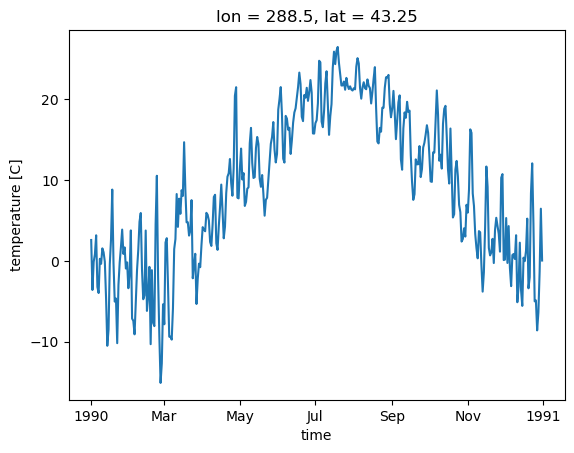

In [6]:
experiment_forcing.to_xarray()["temperature"].plot()

### Derived constants
MARRMoT works with expressing all hydrological fluxes in mm/s and stores in mm. This makes sense from the perspective of the model builders original purpose with MARRMoT: to easily compare different model structures on different regions. However, when comparing the predicted river discharge to observations measured in m3/s, the area of the basin is needed. This is derived from the shapefile in the cell below. 

In [7]:
#TODO: update this to read the shapefile from the forcing, but due to a bug in forcing module, this currently does not work
# wait for update of forcing
shape = shapereader.Reader(shapefile)
#shape = shapereader.Reader(experiment_forcing.shape)
record = next(shape.records())
merrimack_area = record.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", merrimack_area)

The catchment area is: 13016500000.0

### Setting up the model object

To use a hydrological model, supported by ewatercycle, an object from its class must be instantiated. Subsequently a model object is created:

In [8]:
model = ewatercycle.models.MarrmotM01(forcing=experiment_forcing)
print(model)

MarrmotM01(
    parameter_set=None,
    forcing=MarrmotForcing(
        start_time='1990-01-01T00:00:00Z',
        end_time='1990-12-31T00:00:00Z',
        directory=PosixPath('/home/rhut/technicalPaperExampleNotebooks/esmvaltool_output/ewcrepb9k5av4q_20240314_10
3659/work/diagnostic/script'),
        shape=PosixPath('/home/rhut/technicalPaperExampleNotebooks/esmvaltool_output/ewcrepb9k5av4q_20240314_103659
/work/diagnostic/script/settingFiles/Merrimack.shp'),
        forcing_file='marrmot_ERA5_Merrimack_1990_1990.mat'
    )
)

The model also has a version. This version is retrieved from the BMI container image.

To run a different version of the model, you can specify the container image:

```py
from ewatercycle.container import ContainerImage

ewatercycle.models.MarrmotM01(
    forcing=forcing,
    bmi_image=ContainerImage("ewatercycle/marrmot-grpc4bmi:2020.11")
)
```
To view the model's version, do:

In [9]:
model.version

'2020.11'

The model's parameters can be accessed using the .parameters property:

In [10]:
print(model.parameters)

dict_items([('maximum_soil_moisture_storage', 10.0), ('initial_soil_moisture_storage', 0.0), ('solver', 
Solver(name='createOdeApprox_IE', resnorm_tolerance=array([0.1]), resnorm_maxiter=array([6.]))), ('start time', 
'1990-01-01T12:00:00Z'), ('end time', '1990-12-31T12:00:00Z')])

Create config file and start up container for Marrmot

In [11]:
cfg_file, cfg_dir = model.setup(
    # No need to specifiy start and end date, using dates from forcing
    maximum_soil_moisture_storage=experiment_maximum_soil_moisture_storage,
    initial_soil_moisture_storage=experiment_initial_soil_moisture_storage,
)
print(cfg_file)
print(cfg_dir)

/home/rhut/technicalPaperExampleNotebooks/marrmotm01_20240314_103757/marrmot-m01_config.mat

/home/rhut/technicalPaperExampleNotebooks/marrmotm01_20240314_103757

In [12]:
print(model.parameters)

dict_items([('maximum_soil_moisture_storage', 1999.0), ('initial_soil_moisture_storage', 1799.1000000000001), 
('solver', Solver(name='createOdeApprox_IE', resnorm_tolerance=array([0.1]), resnorm_maxiter=array([6.]))), ('start
time', '1990-01-01T00:00:00Z'), ('end time', '1990-12-31T00:00:00Z')])

In [13]:
model.initialize(cfg_file)

### Run model & capture discharge
This is the main loop of an eWaterCycle experiment. As long as the time variable of the model has not surpassed the end time of the experiment, `model.update()` runs a single timestep of the model. the `simulated_discharge` and `timestamps` arrays are filled with the calculated discharge and timestamps respectivly using the `model.get_value()` and `model.time_as_datetime.date()` functions. 

In [14]:
simulated_discharge = []
timestamps = []

while (model.time < model.end_time):
    model.update()
    timestamps.append(model.time_as_datetime.date())
    # Marrmot M01 is a lumped model, so only single value is returned
    value_in_mmday = model.get_value(discharge_variable)[0]
    # Convert from mm/day to m3/s
    value = value_in_mmday * merrimack_area * conversion_mmday2m3s
    simulated_discharge.append(value)

The `timestamps` and `simulated_discharge` variables are now filled with datetime values and discharges for each simulated day.

### Clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [15]:
model.finalize()

### Import GRDC observations

Read the GRDC data for the period of the experiment, for the station given above. 
If you are not on jupyter.ewatercycle.org or Cartesius, download the GRDC https://www.bafg.de/GRDC/EN/02_srvcs/21_tmsrs/riverdischarge_node.html and set the `grdc_location` field in `~/.config/.ewatercycle/ewatercycle.yaml` to your download location.

In [16]:
observations, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=experiment_start_date,
    end_time=experiment_end_date,
)
observations

,streamflow
time,
1990-01-01,119.214
1990-01-02,136.204
1990-01-03,131.107
1990-01-04,133.655
1990-01-05,139.035
...,...
1990-12-27,668.276
1990-12-28,512.534
1990-12-29,419.089


### Plot the results

Combine simulated and observated discharge into a single dataframe

In [17]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': simulated_discharge}, index=pd.to_datetime(timestamps)
)
observations_df = observations.rename(
    columns={'streamflow': 'observation'}
)
discharge = simulated_discharge_df.join(observations_df)
discharge

,simulation,observation
1990-01-02,8.585251,136.204
1990-01-03,0.017747,131.107
1990-01-04,0.002347,133.655
1990-01-05,1.517949,139.035
1990-01-06,0.150252,131.107
...,...,...
1990-12-27,1.074046,668.276
1990-12-28,0.065815,512.534
1990-12-29,974.475217,419.089
1990-12-30,217.302278,393.604


(<Figure size 1000x1000 with 2 Axes>,
 (<Axes: title={'center': 'Hydrograph'}, ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <Axes: >))

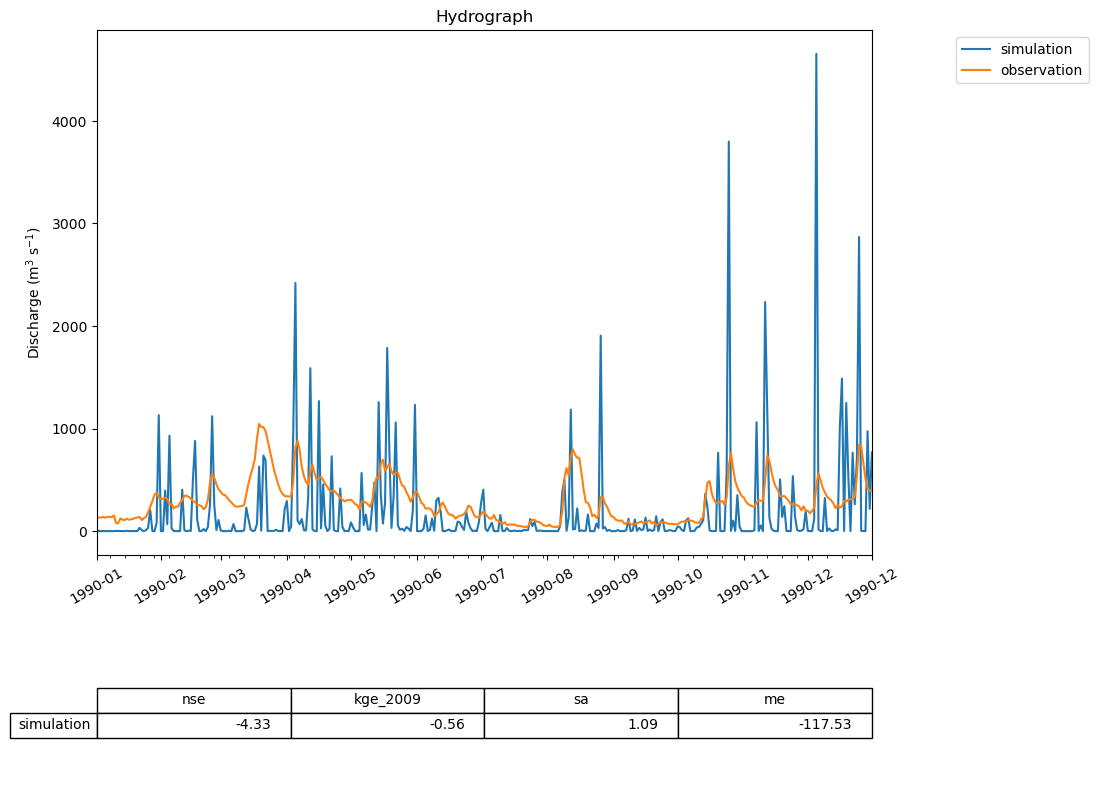

In [18]:
ewatercycle.analysis.hydrograph(
    discharge=discharge,
    reference='observation', 
    filename ='figures/case1_HelloWorldHydrograph.png'
)

## Disclaimer
Obviously the results of this model run do not reflect the observed discharge: we are using a very simple, uncalibrated model for a large basin. This notebook is merely intended to show how to pre-process input data and run hydrological models on the eWaterCycle platform.